In [1]:
#BLOCK1
#二分类，然后再针对回归值进行细分，实现五分类，程序包含BLOCK1
#目前这个程序有问题，二分类（ABC，DE）的正确率有50/60，但细分的时候因为回归值的规律不明显
#（一般规律为A的回归值离0近，B的回归值离0第二近，C离0.5-比较近，D离0.5+比较进，E离1比较近）
#原因可能主要是标签打得不准
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

def sigmoid(x):
    # TODO: Implement sigmoid function
    return 1/(1 + tf.exp(-x))

df=pd.read_csv('C:/Users/16010/Desktop/Spectral_cluster_matlab-master/Sample3.CSV',header=None,sep=' ')
#df=pd.read_csv('C:/Users/16010/Desktop/aa.CSV',header=None,sep=' ')

data = []
for it in df[0]:
    it1 = it.split(",")
    it2 = [float(val) for val in it1]
    data.append(it2)
data = np.array(data)
#data = data.astype(np.float32)
#data = data[0:5,:]
data_tag = copy.copy(data)
mean = data.mean(axis=0)
std = data.std(axis=0)
data = ((data-mean)/std)
print(data.shape)
m = data.shape[0]      #样本个数
n = data.shape[1] - 1    #特征个数


x = tf.placeholder(tf.float32, shape=[n,m], name='x')
y = tf.placeholder(tf.float32, shape=[m,1], name='y')


w = tf.Variable(tf.random_normal([n,1]))
b = tf.Variable(0.0)

z = tf.matmul(w, x, transpose_a=True)
z = tf.transpose(z)
z = tf.add(z, b)

y_hat = 1/(1 + tf.exp(-z))

#loss = tf.reduce_mean(tf.square(y - y_hat, name='loss'))

loss = tf.reduce_mean(-y*tf.log(y_hat + 1e-10)-(1-y)*tf.log(1-y_hat + 1e-10))

optimizer = tf.train.FtrlOptimizer(learning_rate=0.01, l1_regularization_strength=1).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

init_op = tf.global_variables_initializer()
total = []

#x_data = [[1.1, 1.4, 1.7, 1.7, 1.8, 1.8, 1.9, 2.0, 2.3, 2.4],[1.1, 1.5, 1.8, 1.7, 1.9, 1.8, 1.8, 2.1, 2.4, 2.5]]
#y_data = [[16.3], [16.8], [19.2], [18.0], [19.5], [20.9], [21.1], [20.9], [20.3], [22.0]]
#e_data = [[0.8], [-0.5], [0.4], [-0.5], [0.2], [1.9], [1.9], [0.6], [-1.5], [-1.5]]


x_data = data[:,0:n]
#print(x_data)
x_data = x_data.T
y_data = data_tag[:,n:n+1]
print(y_data)

with tf.Session() as sess:
    sess.run(init_op)
    
    writer = tf.summary.FileWriter("E://TensorBoard//test",sess.graph)
    
    for i in range(10000):
        _, l, y_hat_value = sess.run([optimizer, loss, y_hat], feed_dict={x:x_data, y:y_data})
        total.append(l)
        if(i % 1000 == 0):
            accuracy = 0
            #print(y_data,y_hat_value)
            for j in range(len(y_data)):
                
                if y_data[j] == 1 and y_hat_value[j] > 0.5:
                    accuracy = accuracy + 1
                elif y_data[j] == 0 and y_hat_value[j] < 0.5:
                    accuracy = accuracy + 1
            print('epoch{0}:loss{1}'.format(i,l))
            print('right{0} in {1}'.format(accuracy,m))
            print(sess.run([w,b]))
            #print(y_hat_value)
    writer.close()
    w_value = sess.run(w)
    b_value = sess.run(b)
    y_hat_value = sess.run(y_hat, feed_dict={x:x_data, y:y_data})
    print(w_value)
    print(b_value)
    #print(y_hat_value)
    
    #以下部分为细分ABC和DE的过程
    #但先来只代码神兽保佑
    #      
    #          ┌─┐       ┌─┐
    #       ┌──┘ ┴───────┘ ┴──┐
    #       │                 │
    #       │       ───       │
    #       │  ─┬┘       └┬─  │
    #       │                 │
    #       │       ─┴─       │
    #       │                 │
    #       └───┐         ┌───┘
    #           │         │
    #           │         │
    #           │         │
    #           │         └──────────────┐
    #           │                        │
    #           │                        ├─┐
    #           │                        ┌─┘    
    #           │                        │
    #           └─┐  ┐  ┌───────┬──┐  ┌──┘         
    #             │ ─┤ ─┤       │ ─┤ ─┤         
    #             └──┴──┘       └──┴──┘ 
    #                 神兽保佑 
    #                 代码无BUG! 
    #好，开始写了
    
    #根据logistics回归值然后进行细分的界限
    #[0,lab]：A-----[lab,lbc]：B ------[lbc,0.5]：C----------[0.5,lde]：D----------[lde,1]：E
    #初值随便取，无所谓，取得不好训练慢而已
    lab = 0.2
    lbc = 0.4
    lde = 0.8
    
    A = np.zeros([m,2])  #第0列为tag，第1列为回归值
    
    df=pd.read_csv('C:/Users/16010/Desktop/Spectral_cluster_matlab-master/tag1.CSV',header=None,sep=' ')
    for i in range(len(df[0])):
        A[i][0] = df[0][i]
        A[i][1] = y_hat_value[i][0]
    print(A)
    plt.scatter(A[:,0],A[:,1])
    plt.show()
    #下面来使用感知器算法训练lab,lbc,lde
    for i in range(200000):      
        for j in range(m):
            tag = A[j][0]
            reg = A[j][1]
            if(tag == 1):
                if(reg > lab):
                    lab += 0.001*(reg-lab)
            elif(tag == 2):
                if(reg > lbc):
                    lbc += 0.001*(reg-lbc)
                if(reg < lab):
                    lab -= 0.001*(lab-reg)
            elif(tag == 3):
                if(reg < lbc):
                    lbc -= 0.001*(lbc-reg)
            elif(tag == 4):
                if(reg > lde):
                    lde += 0.001*(reg-lde)
            elif(tag == 5):
                if(reg < lde):
                    lde -= 0.001*(lde-reg)
        if i % 10000 == 0:
            print('------------------')
            print("epoch{}".format(i))
            predic = np.zeros(m)
            print("lab:{}".format(lab))
            print("lbc:{}".format(lbc))
            print("lde:{}".format(lde))
            print('------------------')
            acc = 0
            tol = 0
            for j in range(m):
                tag = A[j][0]
                reg = A[j][1]
                if(reg >= 0 and reg < lab):
                    predic[j] = 1
                    tol += 1
                elif(reg >= lab and reg < lbc):
                    predic[j] = 2
                    tol += 1
                elif(reg >= lbc and reg < 0.5):
                    predic[j] = 3
                    tol += 1
                elif(reg >= 0.5 and reg < lde):
                    predic[j] = 4
                    tol += 1
                elif(reg >= lde and reg <= l):
                    predic[j] = 5
                    tol += 1
                if predic[j] == tag:
                    acc += 1
            print("acc:{}/{}".format(acc,tol))
    
plt.plot(total)
plt.show()

C:\Users\16010\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\16010\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\16010\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\16010\AppData\Roaming\Python\Python36\site-

(60, 6)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]
epoch0:loss1.1304420232772827
right29 in 60
[array([[ 0.07854906],
       [-0.14532305],
       [-0.02102978],
       [ 0.00432385],
       [ 0.36337477]], dtype=float32), 0.0]
epoch1000:loss0.5405889749526978
right47 in 60
[array([[-0.37939844],
       [ 0.21958521],
       [-0.53125226],
       [ 0.41672397],
       [-0.04134412]], dtype=float32), -0.025919685]
epoch2000:loss0.5107046961784363
right46 in 60
[array([[-0.5502645 ],
       [ 0.30936703],
       [-0.71601367],
       [ 0.49640867],
       [-0.12059749]], dtype=float32), -0.070930675]
epoch3000:loss0.4945121109485626
right46 in 60
[array([[-0.6795725 ],
      

<Figure size 640x480 with 1 Axes>

------------------
epoch0
lab:0.20023827421321258
lbc:0.40083349489558484
lde:0.7987551144671272
------------------
acc:22/53
------------------
epoch10000
lab:0.22988867806537183
lbc:0.515507833263106
lde:0.6818930697385359
------------------
acc:20/44
------------------
epoch20000
lab:0.22988867806537183
lbc:0.515507833263106
lde:0.6818930697385359
------------------
acc:20/44
------------------
epoch30000
lab:0.22988867806537183
lbc:0.515507833263106
lde:0.6818930697385359
------------------
acc:20/44
------------------
epoch40000
lab:0.22988867806537183
lbc:0.515507833263106
lde:0.6818930697385359
------------------
acc:20/44
------------------
epoch50000
lab:0.22988867806537183
lbc:0.515507833263106
lde:0.6818930697385359
------------------
acc:20/44
------------------
epoch60000
lab:0.22988867806537183
lbc:0.515507833263106
lde:0.6818930697385359
------------------
acc:20/44
------------------
epoch70000
lab:0.22988867806537183
lbc:0.515507833263106
lde:0.6818930697385359
-------

<Figure size 640x480 with 1 Axes>

[[2.00000000e+00 5.18254459e-01]
 [2.00000000e+00 7.68264234e-01]
 [1.00000000e+00 2.10089507e-04]
 [2.00000000e+00 7.25358009e-01]
 [1.00000000e+00 3.80794734e-01]
 [1.00000000e+00 3.51589710e-01]
 [2.00000000e+00 3.38688433e-01]
 [2.00000000e+00 4.39592391e-01]
 [4.00000000e+00 5.99651575e-01]
 [5.00000000e+00 6.57203019e-01]
 [4.00000000e+00 7.31637299e-01]
 [5.00000000e+00 7.66248167e-01]
 [1.00000000e+00 2.60784030e-01]
 [5.00000000e+00 7.88168430e-01]
 [5.00000000e+00 7.56955206e-01]
 [2.00000000e+00 4.98798579e-01]
 [5.00000000e+00 6.15440071e-01]
 [5.00000000e+00 7.60715127e-01]
 [1.00000000e+00 4.45038080e-01]
 [5.00000000e+00 4.80632395e-01]
 [2.00000000e+00 1.78227108e-02]
 [1.00000000e+00 1.24555929e-02]
 [3.00000000e+00 5.52881420e-01]
 [3.00000000e+00 3.10605586e-01]
 [4.00000000e+00 5.89693427e-01]
 [1.00000000e+00 1.51029542e-01]
 [1.00000000e+00 8.52742605e-03]
 [5.00000000e+00 8.17795157e-01]
 [3.00000000e+00 5.24598062e-01]
 [3.00000000e+00 4.78457838e-01]
 [5.000000

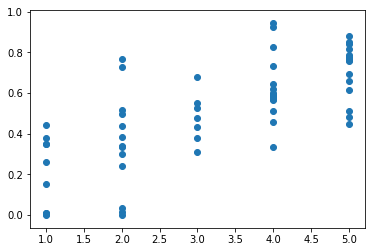

In [6]:
print(A)
plt.scatter(A[:,0],A[:,1])

(60, 12)
epoch0:loss3393.04736328125
right13 in 60
[array([[-0.7638842 ,  0.00411078, -0.30674985, -0.9909795 ,  0.09478718],
       [ 1.0933566 ,  1.5441722 , -0.7085023 ,  0.11136346, -1.2428206 ],
       [ 0.7350862 , -1.0634854 ,  0.6808879 , -0.6771687 , -0.14295807],
       [-0.08020185, -1.0046219 , -0.52381825, -0.96407306,  0.4950879 ],
       [-0.60712177,  1.9816538 , -1.5303335 ,  0.9152506 , -0.5028027 ],
       [ 0.9509888 ,  1.4441631 ,  0.49188533,  0.19525595,  0.28333175],
       [ 0.3331553 , -1.7360764 ,  0.32604465,  0.5046765 , -1.3672451 ],
       [-0.8241071 , -1.1688848 ,  0.32667398,  0.71711093,  1.1581427 ],
       [ 0.6463483 , -0.49839208, -1.4753562 ,  0.8868257 ,  0.38230327],
       [-1.1830273 ,  0.50916445, -1.5274451 ,  1.5236386 , -0.1534419 ],
       [ 0.37939245, -0.269384  , -0.48990798, -0.06739824, -0.52980226]],
      dtype=float32), array([[ 1.8125511 , -1.4191988 , -2.0149436 , -0.00939506,  0.7196759 ]],
      dtype=float32)]
epoch4000:loss

epoch36000:loss759.5355224609375
right44 in 60
[array([[ 1.3515338e+00, -1.1679820e+00, -2.3190260e+00, -3.7052114e+00,
        -2.0558314e+00],
       [ 3.2479556e+00, -6.3892329e-01, -2.5866678e+00, -2.1860073e+00,
        -3.2393651e+00],
       [ 3.1307800e+00,  1.3909237e+00, -1.4409652e+00, -3.2331014e+00,
        -2.8896468e+00],
       [ 7.6931971e-01, -2.8506145e+00, -9.6137244e-01, -1.2460914e+00,
         2.1056459e+00],
       [-2.2982296e-03,  4.9611723e-01,  5.4192996e-01,  2.2875564e+00,
         4.2778370e-01],
       [ 1.5042651e-01,  8.2075876e-01, -6.7162830e-01,  1.1262531e+00,
         1.2605642e+00],
       [ 3.5755059e-01, -3.8837004e-01,  1.2450974e+00, -1.7139618e-01,
        -3.4450471e+00],
       [-1.6243619e-01,  3.3360586e-01, -1.4556845e+00, -2.6373267e-01,
        -4.2919162e-01],
       [ 9.3402809e-01,  7.6121199e-01,  2.4430121e-01, -1.0710512e-01,
        -1.6875027e+00],
       [-2.8869769e-01,  3.8283134e-01, -1.9156149e-01,  4.5835820e-01,
       

epoch68000:loss701.1748657226562
right45 in 60
[array([[ 2.0263214 , -1.1835831 , -2.8420565 , -4.652824  , -2.9706979 ],
       [ 3.9836068 , -1.4325856 , -3.038141  , -2.995865  , -3.9888072 ],
       [ 3.9784498 ,  2.6191351 , -2.0396342 , -4.1419334 , -3.9509625 ],
       [ 0.8246306 , -3.1260443 , -0.88293564, -1.2284474 ,  2.7146974 ],
       [-0.0819586 ,  0.2174556 ,  1.5837669 ,  2.5765257 ,  0.6319461 ],
       [-0.45738268,  0.98746085, -0.8834347 ,  1.1125683 ,  1.2608228 ],
       [ 0.27808776, -0.43842995,  1.3137172 , -0.08096343, -3.8576918 ],
       [ 0.02209355,  0.39580753, -1.9033785 , -0.30766535, -0.68808496],
       [ 1.0836315 ,  0.8392835 ,  0.40408364, -0.0686745 , -2.3546002 ],
       [-0.3316681 ,  0.46524745, -0.16833107,  0.47303686,  0.8742993 ],
       [-0.4963931 ,  0.80056876,  0.17803562,  0.26117754, -0.252347  ]],
      dtype=float32), array([[ 0.27170017,  0.93771607, -1.6505357 , -1.0078251 , -2.957262  ]],
      dtype=float32)]
epoch72000:loss695

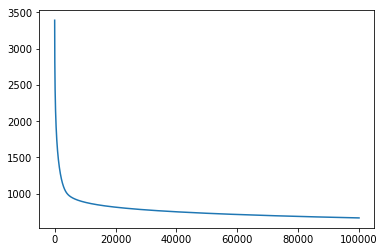

In [2]:
#BLOCK2
#输出直接为5个预测值，然后使用softmax函数进行5分类,程序包含BLOCK2
#直接5分类train dataset的accuracy竟然有45/60，就是75%。。。惊人，明明标签都是自己随便打的。
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

def sigmoid(x):
    # TODO: Implement sigmoid function
    return 1/(1 + tf.exp(-x))

df=pd.read_csv('C:/Users/16010/Desktop/Spectral_cluster_matlab-master/SampleA.CSV',header=None,sep=' ')
#df=pd.read_csv('C:/Users/16010/Desktop/aa.CSV',header=None,sep=' ')

k = 5 #类别个数
data = []
for it in df[0]:
    it1 = it.split(",")
    it2 = [float(val) for val in it1]
    data.append(it2)
data = np.array(data)
#data = data.astype(np.float32)
#data = data[0:5,:]
data_tag = copy.copy(data)
mean = data.mean(axis=0)
std = data.std(axis=0)
data = ((data-mean)/std)
print(data.shape)
m = data.shape[0]      #样本个数
n = data.shape[1] - 1    #特征个数


x = tf.placeholder(tf.float32, shape=[n,m], name='x')
y = tf.placeholder(tf.float32, shape=[m,k], name='y')


w = tf.Variable(tf.random_normal([n,k]))
b = tf.Variable(tf.random_normal([1,k]))

z = tf.matmul(w, x, transpose_a=True)
z = tf.transpose(z)
z = tf.add(z, b)

prediction = tf.nn.softmax(z)
#loss = tf.reduce_mean(tf.square(y - y_hat, name='loss'))

#loss = tf.reduce_mean(-y*tf.log(y_hat + 1e-10)-(1-y)*tf.log(1-y_hat + 1e-10))
loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log(prediction + 1e-10),reduction_indices=1))

optimizer = tf.train.FtrlOptimizer(learning_rate=0.01, l1_regularization_strength=1).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

init_op = tf.global_variables_initializer()
total = []

#x_data = [[1.1, 1.4, 1.7, 1.7, 1.8, 1.8, 1.9, 2.0, 2.3, 2.4],[1.1, 1.5, 1.8, 1.7, 1.9, 1.8, 1.8, 2.1, 2.4, 2.5]]
#y_data = [[16.3], [16.8], [19.2], [18.0], [19.5], [20.9], [21.1], [20.9], [20.3], [22.0]]
#e_data = [[0.8], [-0.5], [0.4], [-0.5], [0.2], [1.9], [1.9], [0.6], [-1.5], [-1.5]]


x_data = data[:,0:n]
#print(x_data)
x_data = x_data.T
y_data = data_tag[:,n:n+1]
y_data_onehot = np.zeros([m,k])
#print(y_data)
for i in range(m):
    y_data_onehot[i][int(y_data[i][0])-1] = 1000
#print(y_data)

with tf.Session() as sess:
    sess.run(init_op)
    
    writer = tf.summary.FileWriter("E://TensorBoard//test",sess.graph)
    
    for i in range(100000):
        _, l, prediction_value = sess.run([optimizer, loss, prediction], feed_dict={x:x_data, y:y_data_onehot})
        total.append(l)
        if(i % 4000 == 0):
            accuracy = 0
            #print(prediction_value,y_data_onehot)
            for j in range(len(y_data_onehot)):
                if y_data[j][0] - 1 == np.argmax(prediction_value[j]):
                    accuracy = accuracy + 1
            print('epoch{0}:loss{1}'.format(i,l))
            print('right{0} in {1}'.format(accuracy,m))
            print(sess.run([w,b]))
            #print(y_hat_value)
    writer.close()
    w_value = sess.run(w)
    b_value = sess.run(b)
    print(w_value)
    print(b_value)
plt.plot(total)
plt.show()

In [138]:
#这个BLOCK只是用来调试的
#这个BLOCK只是用来调试的
#这个BLOCK只是用来调试的
import pandas as pd
import numpy as np

df=pd.read_csv('C:/Users/16010/Desktop/Spectral_cluster_matlab-master/Sample.CSV',header=None,sep=' ') #filename可以直接从盘符开始，标明每一级的文件夹直到csv文件，header=None表示头部为空，sep=' '表示数据间使用空格作为分隔符，如果分隔符是逗号，只需换成 ‘，’即可。
df=pd.read_csv('C:/Users/16010/Desktop/aa.CSV',header=None,sep=' ')
data = []
for it in df[0]:
    it1 = it.split(",")
    it2 = [float(val) for val in it1]
    data.append(it2)

data = np.array(data,dtype=float)
print(data[0][0].dtype)
data = data.astype(np.float32)
m = data.shape[0]     #样本个数
n = data.shape[1] - 1    #特征个数
print(data[0][0].dtype)
x_d = data[:,0:n]
y_d = data[:,n:n+1]
print(x_d.shape)
print(y_d.shape)
#作为示例，输出CSV文件的前5行和最后5行，这是pandas默认的输出5行，可以根据需要自己设定输出几行的值
print(data)
mean = data.mean(axis=0)
std = data.std(axis=0)
print((data-mean)/std)

float64
float32
(1207, 28)
(1207, 1)
[[ 2.0029697  -0.12700559 -1.7554225  ... -0.10524658 -0.07220732
   0.        ]
 [ 1.9296569  -0.21177486 -0.9068356  ... -0.03234118 -0.01774036
   0.        ]
 [-1.8762238   2.4282327  -1.2499489  ...  0.7738275  -0.0279889
   0.        ]
 ...
 [-5.9761195  -7.1969795  -5.3883157  ...  0.5658463  -1.0341072
   1.        ]
 [-0.40811083  3.1329446  -3.0980299  ...  0.23385102  0.11960346
   1.        ]
 [-2.34934     1.512604   -2.6474972  ... -0.7360728   0.7337027
   1.        ]]
[[ 7.5498319e-01 -5.1851362e-01  2.4455026e-01 ... -1.6989362e-01
  -2.1829730e-01 -7.6691467e-01]
 [ 7.4074888e-01 -5.4376638e-01  3.9534569e-01 ... -9.1316782e-02
  -8.5830621e-02 -7.6691467e-01]
 [ 1.8044008e-03  2.4269088e-01  3.3437383e-01 ...  7.7756518e-01
  -1.1075564e-01 -7.6691467e-01]
 ...
 [-7.9422569e-01 -2.6246564e+00 -4.0102139e-01 ...  5.5340481e-01
  -2.5576913e+00  1.3039265e+00]
 [ 2.8685117e-01  4.5262429e-01  5.9665176e-03 ...  1.9558297e-01
   2.48

In [100]:
#这个BLOCK只是用来调试的
#这个BLOCK只是用来调试的
#这个BLOCK只是用来调试的
aaa = tf.constant(np.array([[1],[2],[3],[4],[5]]),dtype=tf.float32)
bbb = 1/(1 + tf.exp(-aaa))

with tf.Session() as sess:
    print(sess.run(bbb))

[[0.7310586 ]
 [0.880797  ]
 [0.95257413]
 [0.98201376]
 [0.9933072 ]]


In [4]:
#这个BLOCK只是用来调试的
#这个BLOCK只是用来调试的
#这个BLOCK只是用来调试的
import numpy as np
y_data_onehot = np.zeros([5,4])
y_data_onehot

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

[[2.00000000e+00 5.18254459e-01]
 [2.00000000e+00 7.68264234e-01]
 [1.00000000e+00 2.10089507e-04]
 [2.00000000e+00 7.25358009e-01]
 [1.00000000e+00 3.80794734e-01]
 [1.00000000e+00 3.51589710e-01]
 [2.00000000e+00 3.38688433e-01]
 [2.00000000e+00 4.39592391e-01]
 [4.00000000e+00 5.99651575e-01]
 [5.00000000e+00 6.57203019e-01]
 [4.00000000e+00 7.31637299e-01]
 [5.00000000e+00 7.66248167e-01]
 [1.00000000e+00 2.60784030e-01]
 [5.00000000e+00 7.88168430e-01]
 [5.00000000e+00 7.56955206e-01]
 [2.00000000e+00 4.98798579e-01]
 [5.00000000e+00 6.15440071e-01]
 [5.00000000e+00 7.60715127e-01]
 [1.00000000e+00 4.45038080e-01]
 [5.00000000e+00 4.80632395e-01]
 [2.00000000e+00 1.78227108e-02]
 [1.00000000e+00 1.24555929e-02]
 [3.00000000e+00 5.52881420e-01]
 [3.00000000e+00 3.10605586e-01]
 [4.00000000e+00 5.89693427e-01]
 [1.00000000e+00 1.51029542e-01]
 [1.00000000e+00 8.52742605e-03]
 [5.00000000e+00 8.17795157e-01]
 [3.00000000e+00 5.24598062e-01]
 [3.00000000e+00 4.78457838e-01]
 [5.000000

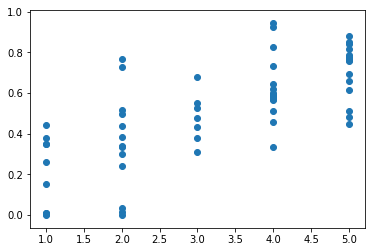

In [5]:
print(A)
plt.scatter(A[:,0],A[:,1])

In [12]:
import pandas as pd
import numpy as np
import copy
df=pd.read_csv('C:/Users/16010/Desktop/Spectral_cluster_matlab-master/tag1.CSV',header=None,sep=' ')
#df=pd.read_csv('C:/Users/16010/Desktop/aa.CSV',header=None,sep=' ')

data = []
for it in df[0]:
    #it1 = it.split(",")
    #t2 = [float(val) for val in it]
    data.append(it)
data = np.array(data)
print(data[0].dtype)
#data = data.astype(np.float32)
#data = data[0:5,:]
#ata_tag = copy.copy(data)
#ean = data.mean(axis=0)
#td = data.std(axis=0)
#ata = ((data-mean)/std)
print(data.shape)

int32
(60,)
